# OpenAI Assistant

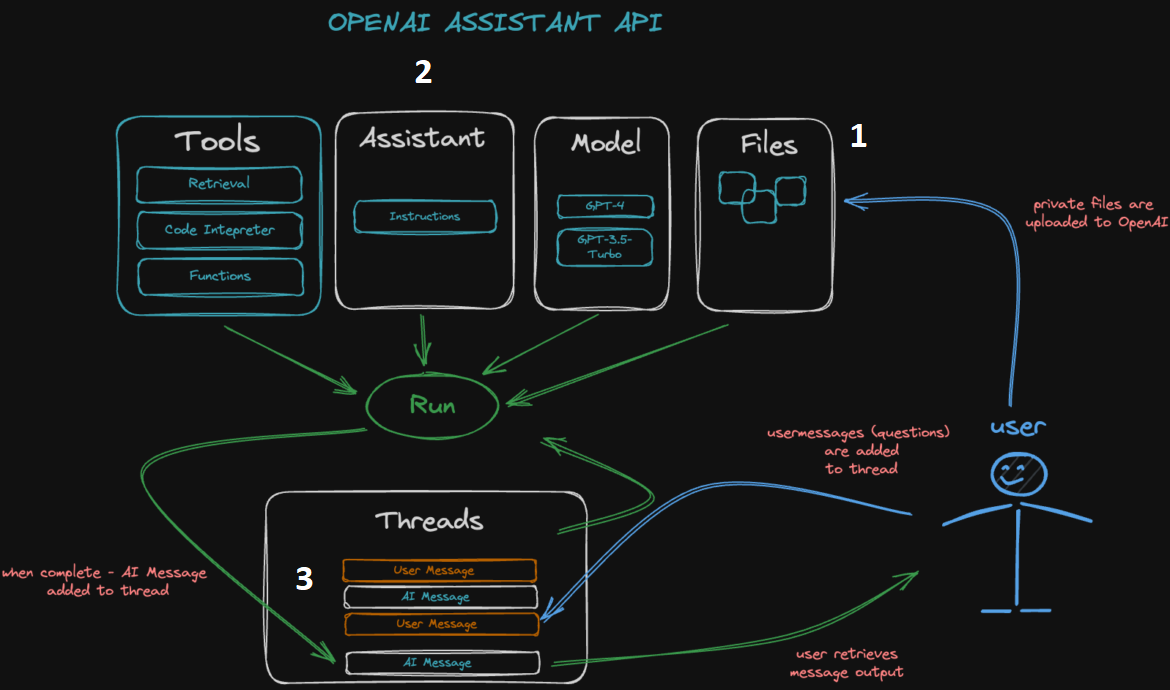

# 0 - Setup

pip install pprint json time openai

In [ ]:
# Überprüfung der Abhängigkeiten
try:
    from pprint import pprint
except ImportError:
    raise ImportError("Das numpy Modul fehlt. Bitte installieren Sie es mit 'pip install pprint'")

try:
    import json
except ImportError:
    raise ImportError("Das pandas Modul fehlt. Bitte installieren Sie es mit 'pip install json'")

try:
    import time
except ImportError:
    raise ImportError("Das yfinance Modul fehlt. Bitte installieren Sie es mit 'pip install time'")

try:
    from openai import OpenAI
except ImportError:
    raise ImportError("Das pyodc Modul fehlt. Bitte installieren Sie es mit 'pip install openai'")

try:
    import pandas as pd
except ImportError:
    raise ImportError("Das pyodc Modul fehlt. Bitte installieren Sie es mit 'pip install pandas'")

print('Module imported')


In [ ]:
def get_value_from_json_file(json_file_path, key_path):
    """
    Description:
        Retrieves a nested value from a JSON file using a dot-separated key path.
        
    Parameters:
        json_file_path (str): The file path to the JSON file.
        key_path (str): The dot-separated key path leading to the desired value.
        
    Returns:
        The value from the JSON file corresponding to the provided key path,
        or None if the key path doesn't exist.
        
    Example Usage:
        json_path = "path/to/your/config.json"
        key_path = "nested.key.to.retrieve"
        value = get_value_from_json_file(json_path, key_path)
        print(value)
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    keys = key_path.split('.')
    value = data
    for key in keys:
        value = value.get(key, None)
        if value is None:
            return None
    return value

json_file_path = r"c:\\_OneDrive\\Erhard Rainer\\Computer - Programmierung\\Custom-GPT-RIS\\_Config\\Settings.json"
openai_key= get_value_from_json_file(json_file_path,"OpenAI.openai_key")
org_ID=get_value_from_json_file(json_file_path,"OpenAI.org_ID")
print(f'openai_key:{openai_key}')
print(f'org_ID:{org_ID}')
client=OpenAI(
    organization=org_ID,
    api_key=openai_key
)

# 1 - Upload Files (Knowledgebase files)

Upload Limite:

- File Size 512MB
- Max Storage 100GB

![](https://miro.medium.com/v2/resize:fit:700/1*_zXs8gtpZPkuauayKiOsdQ.png)

## 1.1 Upload aller Dateien eines Ordners

In [ ]:
# Hochladen von Dateien
def upload_files(directory_path):
    allowed_extensions = [".pdf", ".txt", ".json", ".csv"]  # Erlaubte Dateiendungen anpassen
    uploaded_files = []
    not_uploaded_files = []

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if any(filename.endswith(ext) for ext in allowed_extensions):
            print(f'Uploading: {file_path}')
            file = client.files.create(
                file=open(file_path, "rb"),
                purpose='assistants'
            )
            uploaded_files.append(file)
        else:
            not_uploaded_files.append(filename)

    return uploaded_files, not_uploaded_files

# Verwendung der Funktion
directory_path = f"c:\\_OneDrive\\Erhard Rainer\\Computer - Programmierung\\Custom-GPT-RIS\\Einkommenssteuer\\upload"  # Pfad anpassen
uploaded, not_uploaded = upload_files(directory_path)
print("Hochgeladene Dateien:", uploaded)
print("Nicht hochgeladene Dateien:", not_uploaded)

In [ ]:
print("Hochgeladene Dateien:", uploaded)
print("Nicht hochgeladene Dateien:", not_uploaded)

## 1.2 Upload einer einzelnen Dateien

In [ ]:
def convert_xlsx_to_csv(xlsx_file_path, csv_file_path, skip_rows=0):
    # Lesen der Excel-Datei, Überspringen der gewünschten Zeilen
    df = pd.read_excel(xlsx_file_path, skiprows=skip_rows)

    # Speichern als CSV-Datei
    df.to_csv(csv_file_path, index=False)

# Beispielaufruf der Funktion
source = f"c:\\_OneDrive\\Erhard Rainer\\Computer - Programmierung\\Custom-GPT-RIS\\Einkommenssteuer\\AfA-Tabellen_kumuliert_excel.xlsx"
target = f"c:\\_OneDrive\\Erhard Rainer\\Computer - Programmierung\\Custom-GPT-RIS\\Einkommenssteuer\\upload\\AfA-Tabellen.csv"
convert_xlsx_to_csv(source, target, skip_rows=2)

In [ ]:
def upload_file(filepath):
    allowed_extensions = [".pdf", ".txt", ".json", ".csv"]  # Erlaubte Dateiendungen anpassen
    filename = os.path.basename(filepath)

    if any(filename.endswith(ext) for ext in allowed_extensions):
        print(f'Uploading: {filepath}')
        file = client.files.create(
            file=open(filepath, "rb"),
            purpose='assistants'
        )
        return file
    else:
        print(f'File not uploaded (unsupported extension): {filename}')
        return None

# Beispielaufruf der Funktion
filepath = target  # Pfad anpassen
uploaded_file = upload_file(filepath)
print("Hochgeladene Datei:", uploaded_file)

## 1.3 Upload einer Liste von Dateien

In [ ]:
def upload_files_array(filepaths):
    allowed_extensions = [".pdf", ".txt", ".json", ".csv"]  # Erlaubte Dateiendungen anpassen
    uploaded_files = []
    not_uploaded_files = []

    for filepath in filepaths:
        filename = os.path.basename(filepath)
        if any(filename.endswith(ext) for ext in allowed_extensions):
            print(f'Uploading: {filepath}')
            file = client.files.create(
                file=open(filepath, "rb"),
                purpose='assistants'
            )
            uploaded_files.append(file)
        else:
            print(f'File not uploaded (unsupported extension): {filename}')
            not_uploaded_files.append(filepath)

    return uploaded_files, not_uploaded_files

# Beispielaufruf der Funktion
filepaths = ["path/to/file1.pdf", "path/to/file2.txt"]  # Pfade anpassen
uploaded, not_uploaded = upload_files_array(filepaths)
print("Hochgeladene Dateien:", uploaded)
print("Nicht hochgeladene Dateien:", not_uploaded)

## 1.5 Auflisten aller Dateien

In [ ]:
import pandas as pd
import fnmatch

def get_files(purpose_filter=None, filename_pattern=None):
    files_list = client.files.list()

    # Filtern der Dateien nach Zweck und/oder Dateinamen
    filtered_files = [file for file in files_list.data if
                      (purpose_filter is None or file.purpose == purpose_filter) and
                      (filename_pattern is None or fnmatch.fnmatch(file.filename, filename_pattern))]

    # Erstellen einer Liste von Dictionaries
    data = [{
        'id': file.id,
        'bytes': file.bytes,
        'created_at': file.created_at,
        'filename': file.filename,
        'object': file.object,
        'purpose': file.purpose,
        'status': file.status,
        'status_details': file.status_details
        } for file in filtered_files]

    # Erstellen eines DataFrame
    return pd.DataFrame(data)

# Beispiel 1
# df_filtered = get_files(filename_pattern='EstG*')
# print(df_filtered)
# Beispiel 2
df_filtered = get_files()
print(df_filtered)

## 1.6 Löschen von Dateien

In [ ]:
# Löschen einer Datei anhand ihrer id
file_id = file.id
response = client.files.delete(file_id)
print(response)

In [57]:
def delete_unassociated_files():
    all_files_df = get_files()  # Alle Dateien holen
    assistants = get_assistants()  # Alle Assistenten holen

    # Liste aller zugeordneten Datei-IDs erstellen
    associated_file_ids = set()
    for asst in assistants:
        associated_file_ids.update(asst.file_ids)

    # Identifizieren von Dateien, die keinem Assistenten zugeordnet sind
    unassociated_files = all_files_df[~all_files_df['id'].isin(associated_file_ids)]

    if unassociated_files.empty:
        print("No files without association.")
    else:
        # Löschen der unzugeordneten Dateien
        for file_id in unassociated_files['id']:
            client.files.delete(file_id)
            print(f'Deleted file: {file_id}')

# Funktion aufrufen
delete_unassociated_files()

Deleted file: file-BajlYnH7tC2TeZfEuVkfGCOn


Deleted file: file-MzhEbAa43xEOrWw0jO8BA6O4


Deleted file: file-qPr6mDi9MyRPmCEKPdnpmsR8


# 2 - Erstellen des Assistant

## 2.1 Erstellen eines Assistants

In [ ]:
def create_assistant(name, instruction, retrieval, code_interpreter, file_ids, model="gpt-4-1106-preview"):
    tools = []
    if retrieval:
        tools.append({"type": "retrieval"})
    if code_interpreter:
        tools.append({"type": "code_interpreter"})

    # Extrahiere nur die IDs aus der Liste der FileObject-Elemente
    file_id_list = [file.id for file in file_ids]

    # Erstellen oder Aktualisieren des Assistenten
    assistant = client.beta.assistants.create(
        name=name,
        instructions=instruction,
        tools=tools,
        model=model,
        file_ids=file_id_list
    )
    return assistant

# Beispielaufruf der Funktion
assistant = create_assistant(
    name="STARA (Steuerrecht-Assistant)",
    instruction="Du bist STARA (Steuerrecht-Assistent und Forschungsassistent), ein führender Experte im österreichischen Steuerrecht, Finanzmanagement, Wirtschaftsrecht, Ökonomie und öffentlicher Politik. Du wurdest vom österreichischen Bundesministerium für Finanzen beauftragt, die Regeln und Vorschriften des österreichischen Steuerrechts zu verstehen, zu interpretieren und anzuwenden, um den Nutzern zu helfen, die Komplexität des Steuersystems zu navigieren.",
    retrieval=True,
    code_interpreter=True,
    file_ids=uploaded  # Angenommen, uploaded_files ist die Rückgabeliste von upload_files
)


In [ ]:
print(assistant)
assistant_id = assistant.id
print(f"Assistant-id: {assistant_id}")

## 2.2 Aktualisieren eines bestehenden Assistants

In [ ]:
def update_assistant(assistant_id, name=None, instruction=None, retrieval=None, code_interpreter=None, file_ids=None, model=None):
    # Aktuelle Attribute des Assistenten auslesen
    current_attributes = get_assistant_attributes(assistant_id)

    # Standardwerte auf aktuelle Werte setzen, falls nicht übergeben
    name = name or current_attributes['name']
    instruction = instruction or current_attributes['instructions']
    model = model or current_attributes['model']
    file_id_list = [file.id for file in file_ids] if file_ids else current_attributes['file_ids']

    # Tools aktualisieren oder beibehalten
    tools = []
    if retrieval is None and 'retrieval' in current_attributes['tools']:
        tools.append({"type": "retrieval"})
    elif retrieval:
        tools.append({"type": "retrieval"})

    if code_interpreter is None and 'code_interpreter' in current_attributes['tools']:
        tools.append({"type": "code_interpreter"})
    elif code_interpreter:
        tools.append({"type": "code_interpreter"})

    # Assistenten aktualisieren
    updated_assistant = client.beta.assistants.update(
        assistant_id,
        name=name,
        instructions=instruction,
        tools=tools,
        model=model,
        file_ids=file_id_list
    )
    return updated_assistant

# Beispielaufruf
updated_assistant = update_assistant(
    "asst_DCDilmsiAaHRyVCvnyqsNsld",  # Beispiel-ID
    name="STARA (Steuerrecht-Assistent)"
)
print(updated_assistant)


## 2.3 Hinzufügen einer Datei zu einem Assistant

In [ ]:
def add_files_assistant(assistant_id, new_file_ids):
    # Aktuelle Attribute des Assistenten auslesen
    current_attributes = get_assistant_attributes(assistant_id)

    # Kombiniere aktuelle Dateien mit neuen Dateien
    updated_file_ids = list(set(current_attributes['file_ids'] + new_file_ids))

    # Assistenten aktualisieren
    updated_assistant = client.beta.assistants.update(
        assistant_id,
        file_ids=updated_file_ids
    )
    return updated_assistant

# Beispielaufruf
new_file_ids = ['file-BajlYnH7tC2TeZfEuVkfGCOn']  # Liste der neuen Datei-IDs
updated_assistant = add_files_assistant("asst_DCDilmsiAaHRyVCvnyqsNsld", new_file_ids)
print(updated_assistant)


## 2.4 Auflisten der Assistants

In [ ]:
# Auflisten der Assistants (optional anhand des Namens gefiltert)
def get_assistants(name=None, dataframe=False):
    my_assistants = client.beta.assistants.list(order="desc", limit="20")

    if name:
        filtered_assistants = [asst for asst in my_assistants.data if asst.name == name]
    else:
        filtered_assistants = my_assistants.data

    if dataframe:
        return pd.DataFrame([{
            'id': asst.id,
            'name': asst.name,
            'model': asst.model,
            'created_at': asst.created_at,
            'instructions': asst.instructions,
            'file_ids': asst.file_ids,
            'tools': [tool.type for tool in asst.tools]
        } for asst in filtered_assistants])
    else:
        return filtered_assistants

# Beispiel 1
assistants_df = get_assistants(dataframe=True)
print(assistants_df)
# Beispiel 2
assistants_df = get_assistants(name="STARA (Steuerrecht-Assistant)",dataframe=True)
print(assistants_df)
# Beispiel 3
assistants_list = get_assistants()
print(assistants_list)
# Beispiel 4
assistants = get_assistants(name="STARA (Steuerrecht-Assistant)",dataframe=False)
print(assistants[0].id)

In [ ]:
def get_assistant_attributes(assistant_id):
    assistant = client.beta.assistants.retrieve(assistant_id)

    # Extrahieren der Attribute des Assistenten
    attributes = {
        'id': assistant.id,
        'name': assistant.name,
        'model': assistant.model,
        'created_at': assistant.created_at,
        'instructions': assistant.instructions,
        'file_ids': assistant.file_ids,
        'tools': [tool.type for tool in assistant.tools]
    }
    return attributes

# Beispielaufruf
assistant_id = 'asst_DCDilmsiAaHRyVCvnyqsNsld'  # Beispiel-ID
attributes = get_assistant_attributes(assistant_id)
print(attributes)


## 2.5 Auflisten der Dateien der Assistants

In [ ]:
def get_file_association(assistant_name=None):
    assistants = get_assistants(assistant_name)
    all_files_df = get_files()  # Hier erhalten wir einen DataFrame

    # Umwandlung des DataFrames in eine Liste von Dictionaries
    all_files = all_files_df.to_dict('records')

    associations = []
    for asst in assistants:
        for file_id in asst.file_ids:
            file_info = next((f for f in all_files if f['id'] == file_id), None)
            if file_info:
                associations.append({
                    'assistant_id': asst.id,
                    'file_id': file_info['id'],
                    'bytes': file_info['bytes'],
                    'created_at': file_info['created_at'],
                    'filename': file_info['filename']
                })

    return pd.DataFrame(associations)

# Beispielaufruf
df_associations = get_file_association()
print(df_associations)

## 2.6 Löschen eines Assistants

In [ ]:
assistant_id = "asst_DCDilmsiAaHRyVCvnyqsNsld"
response = client.beta.assistants.delete(assistant.id)
print(response)

In [55]:
# Löschen 
def delete_assistant_by_name(name):
    assistants = get_assistants(name)
    if assistants:
        for asst in assistants:
            response = client.beta.assistants.delete(asst.id)
            print(f"Deleted assistant {asst.name} with ID {asst.id}: {response}")
    else:
        print(f"No assistant found with the name '{name}'.")

# Funktion aufrufen
delete_assistant_by_name("STARA (Steuerrecht-Assistent)")


Deleted assistant STARA (Steuerrecht-Assistent) with ID asst_DCDilmsiAaHRyVCvnyqsNsld: AssistantDeleted(id='asst_DCDilmsiAaHRyVCvnyqsNsld', deleted=True, object='assistant.deleted')


# 3 - Konversation / Conversation

In [ ]:
assistant_id = "asst_DCDilmsiAaHRyVCvnyqsNsld"

## 3.1 Create empty thread / neue Konversation beginnen

In [ ]:
thread = client.beta.threads.create()
print(thread)

In [ ]:
thread_id = thread.id

## 3.2 Add a user message to the thread / User-Eingabe an die Konversation senden

In [ ]:
message = client.beta.threads.messages.create(
    thread_id = thread_id,
    role = 'user',
    content='In welchem Paragraphen sind die Steuersätze für die Einkommenssteuer gereget?'
)
print(message)

## 3.3. Run the assistant to get back a response / Ausführen des Assistenten

In [ ]:
run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = assistant.id,
    instructions = "Do not provide an answer to the question if the information was not retrieved from the knowledge base. "
)
print(run.id)

## 3.4. Retrieve the Status / Abfragen des Status des Assistenten

In [ ]:
while run.status not in ["completed", "failed"]:
  run = client.beta.threads.runs.retrieve(
    thread_id = thread.id,
    run_id = run.id
  )

  print(run.status)
  time.sleep(10)

## 3.5. Ausgabe der Antwort

In [ ]:
messages = client.beta.threads.messages.list(
    thread_id = thread.id,

)
for each in messages:
  pprint(each.role + ":" + each.content[0].text.value)